# Style Transfer by PyTorch & Horovod
### 本Notebookでは、Pytorch + HorovodによるStyle Transferで使って、顔写真をピカソ風に変換します。

## 1. 事前準備

### Azure Machine Learning service Python SDKインポート

In [1]:
from azureml.core import *
print(azureml.core.__version__)

1.0.55


### Workspace への接続

In [2]:
ws = Workspace.from_config()
print('Workspace name: ' + ws.name, 
      'Azure region: ' + ws.location, 
      'Subscription id: ' + ws.subscription_id, 
      'Resource group: ' + ws.resource_group, sep = '\n')

Workspace name: azureml
Azure region: eastus
Subscription id: 9c0f91b8-eb2f-484c-979c-15848c098a6b
Resource group: mlservice


### 実験名の指定

In [3]:
experiment = Experiment(ws, name='pytorch-styletransfer')

### GPU環境の準備

In [4]:
from azureml.core.compute import *
compute_target = ComputeTarget(ws, name = "gpucluster")

## 2. 学習データの準備
### クラウドにアップロードしたMicrosoft COCOデータセットを利用

<div align="left">
<img src="coco-logo.png">
 </div>

In [5]:
ds = ws.get_default_datastore()
ds_data = ds.path('image')

In [6]:
#データアップロード
# ds.upload(src_dir='./image', target_path='./image', show_progress=True)

## 3. モデル学習

### スタイル画像

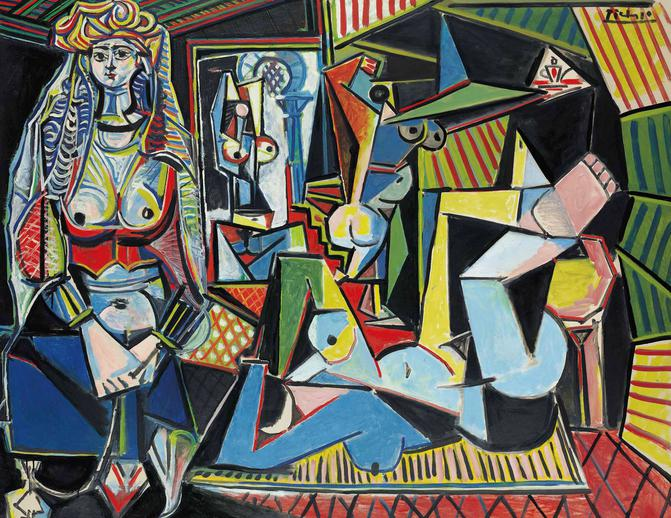

In [7]:
# アルジェの女たち
from IPython.display import Image
Image(filename='neural_style/picasso.jpg') 

### 学習設定

In [8]:
from azureml.train.dnn import PyTorch

#引数の設定
script_params = {
    '--dataset': ds_data.as_mount(),
    '--style-image': 'picasso.jpg',
    '--save-model-dir': './outputs',
    '--epochs': 2,
    '--cuda': 1,
    '--log-interval': 100,
    '--model-name': 'picasso'
}

In [10]:
#モデル学習の設定(学習スクリプト、GPUノード数 etc)
estimator = PyTorch(source_directory='./neural_style', 
                    script_params=script_params,
                    compute_target=compute_target,
                    entry_script='neural_style.py',
                    node_count=3,
                    process_count_per_node=1,
                    distributed_training='mpi',
                    use_gpu=True)

WARNING - framework_version is not specified, defaulting to version 1.1.


### モデル学習の実行

In [11]:
run = experiment.submit(estimator)

In [18]:
from azureml.widgets import RunDetails
RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

### モデル登録

In [19]:
model = run.register_model(model_name = 'picasso-style', model_path = 'outputs/picasso.pth')
#run.download_file("outputs/picasso.pth","outputs/picasso.pth")
print(model.name, model.id, model.version, sep = '\t')

picasso-style	picasso-style:3	3


## 4. 推論

### モデルのロード

In [21]:
model.download(target_dir="outputs", exist_ok=True)

'outputs/picasso.pth'

In [24]:
from torchvision import transforms
from transformer_net import TransformerNet
import time
import re
import sys
import warnings

model = TransformerNet()
state_dict = torch.load('outputs/picasso.pth')
# remove saved deprecated running_* keys in InstanceNorm from the checkpoint
for k in list(state_dict.keys()):
    if re.search(r'in\d+\.running_(mean|var)$', k):
        del state_dict[k]
model.load_state_dict(state_dict)
model.eval()

TransformerNet(
  (conv1): ConvLayer(
    (reflection_pad): ReflectionPad2d((4, 4, 4, 4))
    (conv2d): Conv2d(3, 32, kernel_size=(9, 9), stride=(1, 1))
  )
  (in1): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (conv2): ConvLayer(
    (reflection_pad): ReflectionPad2d((1, 1, 1, 1))
    (conv2d): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
  )
  (in2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (conv3): ConvLayer(
    (reflection_pad): ReflectionPad2d((1, 1, 1, 1))
    (conv2d): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
  )
  (in3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (res1): ResidualBlock(
    (conv1): ConvLayer(
      (reflection_pad): ReflectionPad2d((1, 1, 1, 1))
      (conv2d): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    )
    (in1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (

### テスト画像による推論

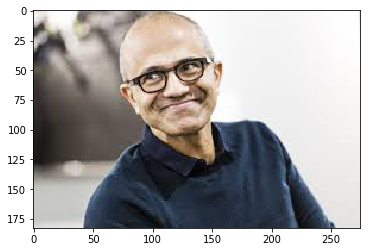

In [39]:
%matplotlib inline
import os, json
from PIL import Image
import matplotlib.pyplot as plt

# 対象画像の指定
base_image = "./test/satya.jpg"
plt.imshow(Image.open(base_image))

In [40]:
import requests
import numpy as np
from torchutil import *

content_image = convert(base_image)
input_data = json.dumps({'content': content_image.tolist()})

In [41]:
input_data = torch.tensor(json.loads(input_data)['content'])
with torch.no_grad():
    start = time.time()
    output = model(input_data)
    end = time.time()
img = output[0].clone().clamp(0, 255).numpy()
img = img.transpose(1, 2, 0).astype("uint8")

In [42]:
im = Image.fromarray(np.uint8(img))
im.save('stylized.jpg')

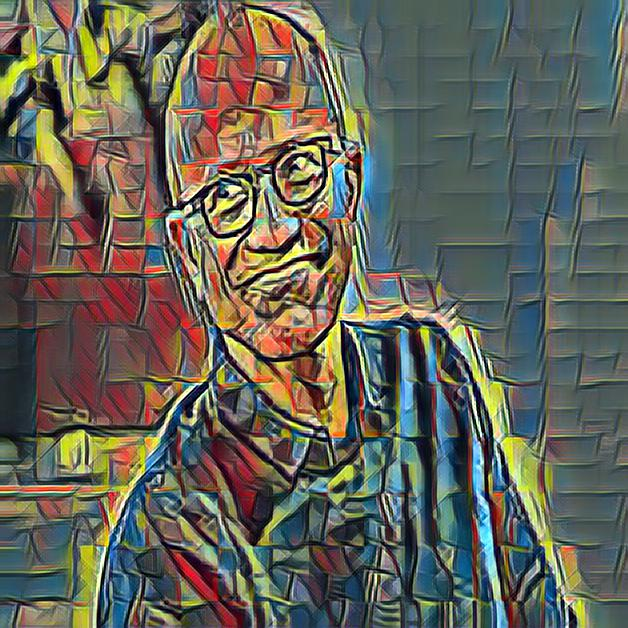

In [43]:
from IPython.display import Image
Image(filename='stylized.jpg')